# Soft Labels as Regularizers
This notebook demonstrates how soft labels reduce model variance and can transfer knowledge of a trained model to another simpler one 

In [1]:
import numpy as np
import matplotlib.pyplot as plt

import tensorflow as tf
from tensorflow.keras.layers import Dense, Input
from tensorflow.keras import Model

from sklearn.datasets import make_moons
from sklearn.preprocessing import MinMaxScaler
from sklearn.tree import DecisionTreeRegressor, DecisionTreeClassifier
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split

## Sythetic data
We create a simple dataset of 2 moons with high overlap due to noise.  
This will highligh the importance of regularization in our model

In [2]:
X, y = make_moons(n_samples=3000, noise=0.3)

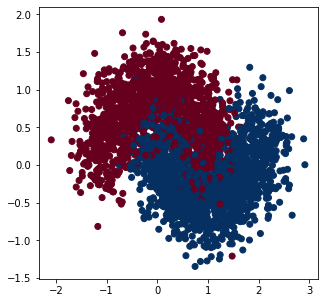

In [3]:
plt.figure(figsize=(5, 5))
plt.scatter(X[:, 0], X[:, 1], c=y, cmap=plt.cm.RdBu)

In [4]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

## Train a "big" model on raw data
Let's say that the above problem is hard, meaning that we need
- An ensemble of models to reduce overfitting and achieve good generalization performance
- Or a large regularized neural network specialized in this dataset

In any case, this would be a model requiring special infrastructure for training and long inference times.

For this toy example we will use a multilayer fully-connected neural network as our "big" model

In [5]:
model = tf.keras.Sequential([
    Dense(128, use_bias=True, input_shape=(2,), activation="relu"),
    Dense(128, activation="relu"),
    Dense(2, activation="relu")
])

In [6]:
model.compile(
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
    optimizer=tf.keras.optimizers.Adam(),
    metrics=["accuracy"])

In [7]:
model.fit(X_train, y_train, batch_size=100, epochs=100, verbose=0, validation_split=0.2)

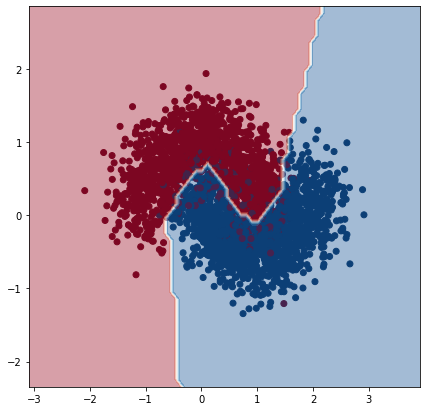

In [8]:
plt.figure(figsize=(7, 7))
plt.scatter(X[:, 0], X[:, 1], c=y, cmap=plt.cm.RdBu)

x_min, x_max = X[:, 0].min() - 1, X[:, 0].max() + 1
y_min, y_max = X[:, 1].min() - 1, X[:, 1].max() + 1
xx, yy = np.meshgrid(np.arange(x_min, x_max, 0.1), np.arange(y_min, y_max, 0.1))

Z = model.predict(np.c_[xx.ravel(), yy.ravel()])
Z = np.argmax(Z, axis=1)
Z = Z.reshape(xx.shape)

plt.contourf(xx, yy, Z, alpha=0.4, cmap=plt.cm.RdBu)

In [9]:
y_pred = model.predict(X_test)
y_pred = np.argmax(y_pred, axis=1)

accuracy_score(y_test, y_pred)

0.9

We can observe 2 things:
- The model achieved good accuracy on test set
- The decision boundary is smooth (doesn't overfit)

## Let a Decision Tree overfit original data
If we were to train a decision tree directly on original labels without using any pruning techniques, we expect it to overfit and have bad generalization performance

In [10]:
tree_model = DecisionTreeClassifier()
tree_model.fit(X_train, y_train)

DecisionTreeClassifier()

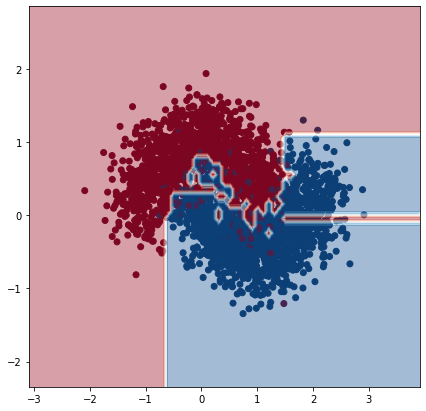

In [11]:
plt.figure(figsize=(7, 7))
plt.scatter(X[:, 0], X[:, 1], c=y, cmap=plt.cm.RdBu)

x_min, x_max = X[:, 0].min() - 1, X[:, 0].max() + 1
y_min, y_max = X[:, 1].min() - 1, X[:, 1].max() + 1
xx, yy = np.meshgrid(np.arange(x_min, x_max, 0.1), np.arange(y_min, y_max, 0.1))

Z = tree_model.predict(np.c_[xx.ravel(), yy.ravel()])
Z = Z.reshape(xx.shape)

plt.contourf(xx, yy, Z, alpha=0.4, cmap=plt.cm.RdBu)

In [12]:
y_pred_tree = tree_model.predict(X_test)

accuracy_score(y_test, y_pred_tree)

0.865

Indeed, test accuracy is low and the decision boundary captures the dataset noise and has many artifacts

## Train a Decision Tree on soft labels
Now, let's use the logits of the last layer of our first "big" model as soft labels and train on them a regression tree

In [13]:
y_train_soft = model.predict(X_train)

In [14]:
distill_model = DecisionTreeRegressor()
distill_model.fit(X_train, y_train_soft)

DecisionTreeRegressor()

In [15]:
distill_model.get_depth()

19

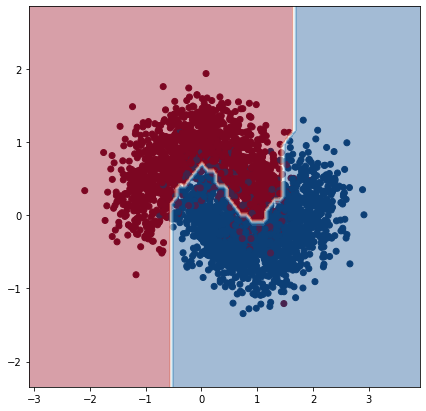

In [16]:
plt.figure(figsize=(7, 7))
plt.scatter(X[:, 0], X[:, 1], c=y, cmap=plt.cm.RdBu)

x_min, x_max = X[:, 0].min() - 1, X[:, 0].max() + 1
y_min, y_max = X[:, 1].min() - 1, X[:, 1].max() + 1
xx, yy = np.meshgrid(np.arange(x_min, x_max, 0.1), np.arange(y_min, y_max, 0.1))

Z = distill_model.predict(np.c_[xx.ravel(), yy.ravel()])
Z = np.argmax(Z, axis=1)
Z = Z.reshape(xx.shape)

plt.contourf(xx, yy, Z, alpha=0.4, cmap=plt.cm.RdBu)

In [17]:
y_pred_distill = distill_model.predict(X_test)
y_pred_distill = np.argmax(y_pred_distill, axis=1)

accuracy_score(y_test, y_pred_distill)

0.9

As previously, we let the tree grow indefinitely, until all leaves are pure or contain up to 2 samples.  
However, in this case 2 things happened:
- The soft labels acted as regularizers and even without any pruning step, the decision boundary is smooth
- Test accuracy not only improved but matched the accuracy of the "big" model (neural network)

Although this is a simplistic dataset, we managed to distill a neural network to a decision tree